In [45]:
# imports
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10, 8]

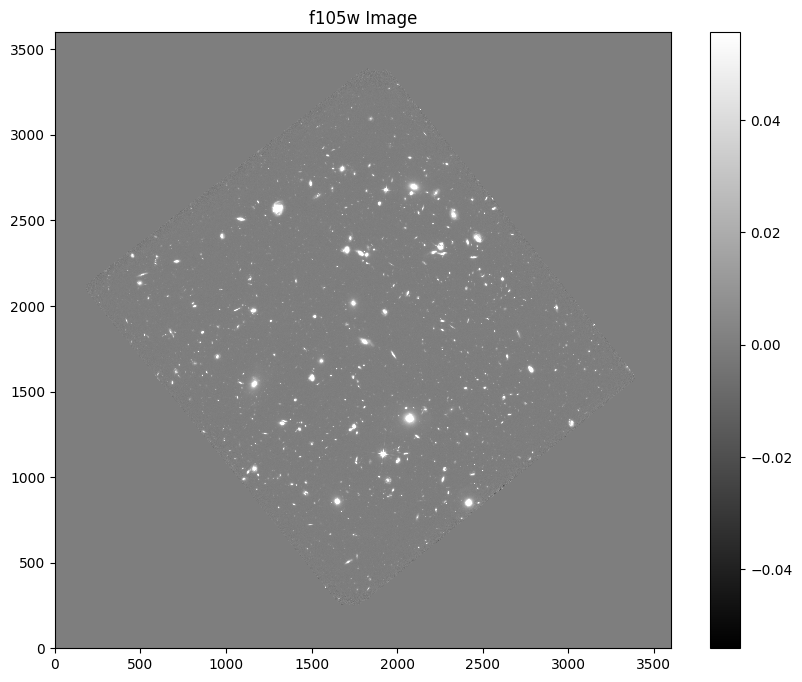

In [46]:
# give variables to the files
f105 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
f125 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
f160 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

# read image with astropy
hdu = fits.open(f105)
data = hdu[0].data.astype(np.float32) 

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title('f105w Image')
plt.savefig('udf_f105w_image.png', dpi=200)
plt.show()

In [47]:
bkg = sep.Background(data)

In [48]:
# print bkg data
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


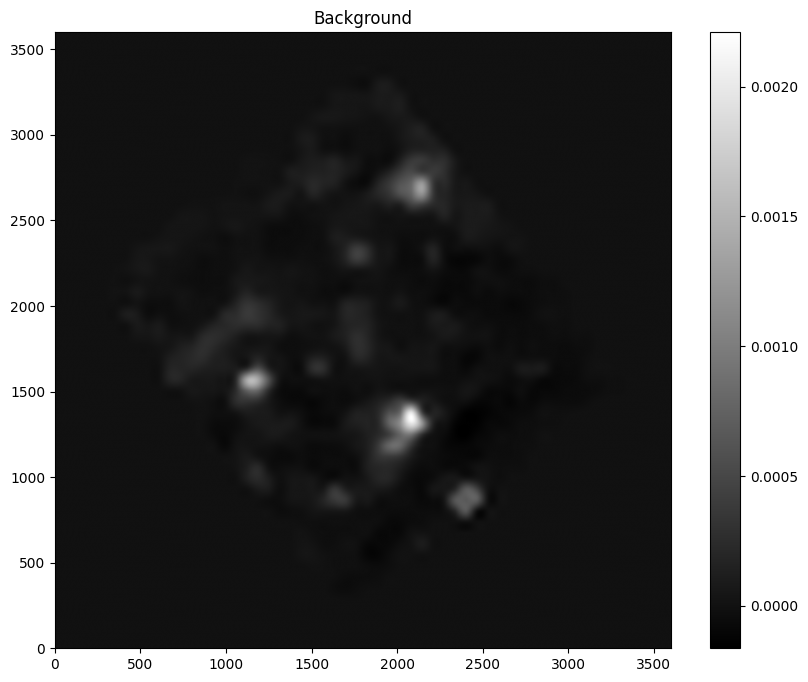

In [49]:
# show bkg color 
bkg_img = bkg.back()
plt.imshow(bkg_img, cmap='grey', origin='lower')
plt.colorbar()
plt.title('Background')
plt.savefig('udf_f105w_background.png', dpi=200)
plt.show()

In [50]:
bkg_rms = bkg.rms()

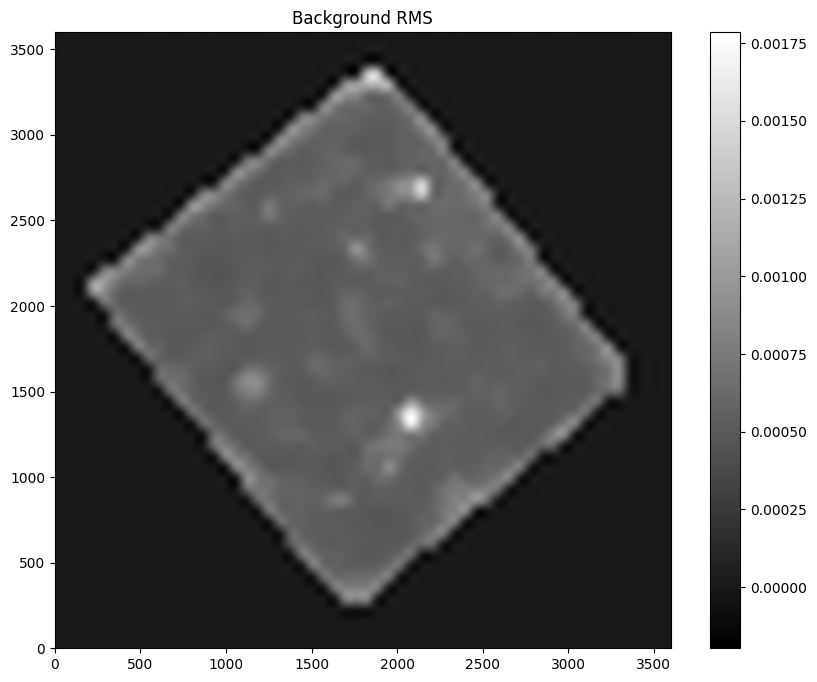

In [51]:
# show bkg rms color
plt.imshow(bkg_rms, cmap='grey', origin='lower')
plt.colorbar()
plt.title('Background RMS')
plt.savefig('udf_f105w_background_rms.png', dpi=200)
plt.show()

In [52]:
data_sub = data - bkg

In [53]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [54]:
# amt of objects identified
len(objects)

8642

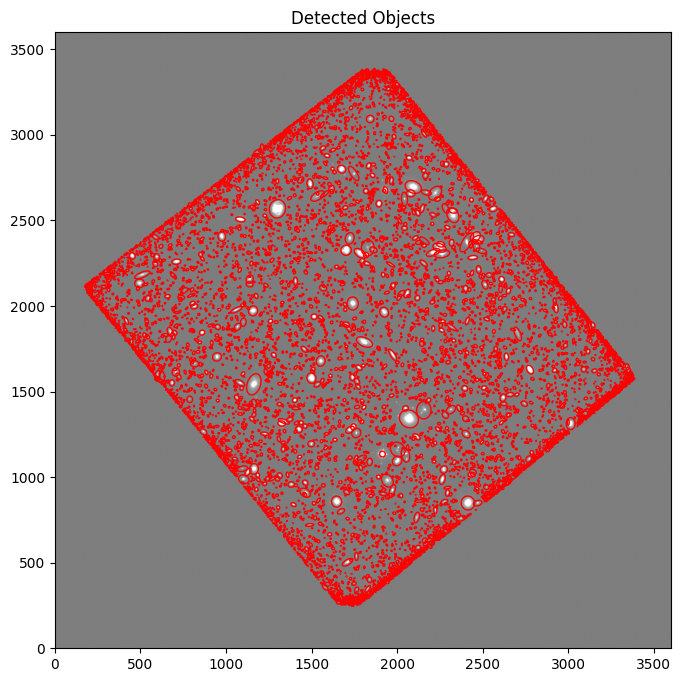

In [55]:
# place img on sub plot
fig,ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
ax.imshow(data_sub, cmap='grey', vmin=m-s, vmax=m+s, origin='lower')

# locate all objects
for i in range(len(objects)):
    e = Ellipse(
        xy=(objects['x'][i], objects['y'][i]),
        width=6 * objects['a'][i],
        height=6 * objects['b'][i],
        angle=objects['theta'][i] * 180 / np.pi
    )
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_patch(e)

plt.title('Detected Objects')
plt.savefig('udf_f105w_detected_objects.png', dpi=200)
plt.show()

In [56]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [57]:
# measures fluxes of all detected objects
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0,err=bkg.globalrms, gain =1.0)

In [58]:
# loop for first 10 objects
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


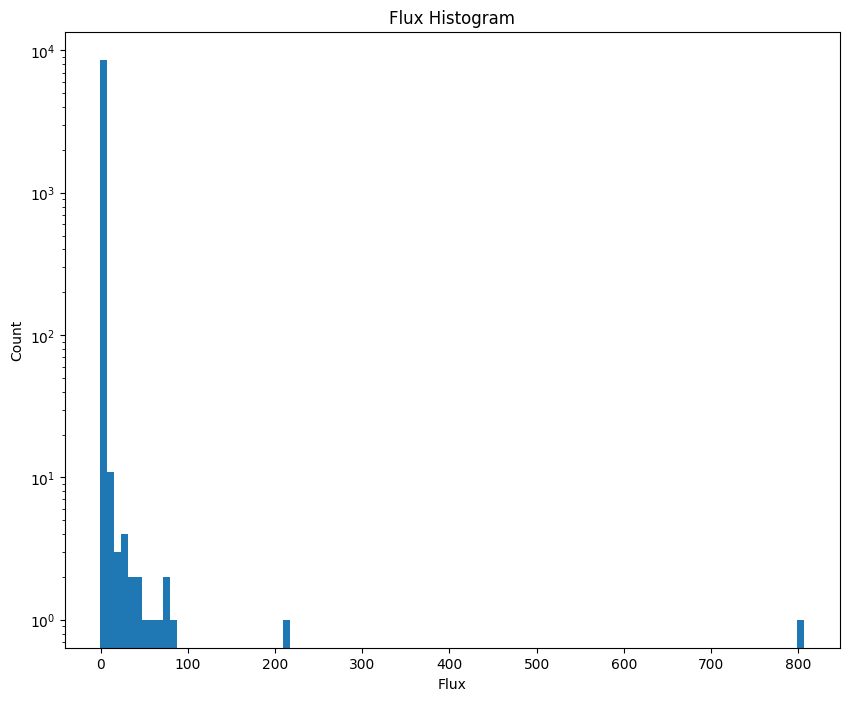

In [59]:
# create histogram
plt.hist(flux, bins=100, log=True)
plt.xlabel('Flux')
plt.ylabel('Count')
plt.title('Flux Histogram')
plt.savefig('udf_f105w_flux_hist.png', dpi=200)
plt.show()

In [60]:
# print and calculate mean, median, and std
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)
print('Mean flux:', mean_flux)
print('Median flux:', median_flux)
print('Standard deviation:', std_flux)

Mean flux: 0.3617744944351508
Median flux: 0.030956558069156016
Standard deviation: 9.242459957717314


In [61]:
# locate pos of max flux
idx = np.argmax(flux)
max_flux = flux[idx]
xpos, ypos = objects['x'][idx], objects['y'][idx]

In [62]:
# calculate sigma
sig = (max_flux - np.mean(flux)) / np.std(flux)

In [63]:
# print brightness level of max flux, locate max flux, and print sigma
print('Brightest flux:', max_flux)
print('Location (x, y):', xpos, ypos)
print('Sigma above mean:', sig)

Brightest flux: 807.2972835731507
Location (x, y): 1914.2549094883857 1134.3164850742164
Sigma above mean: 87.30743901194147


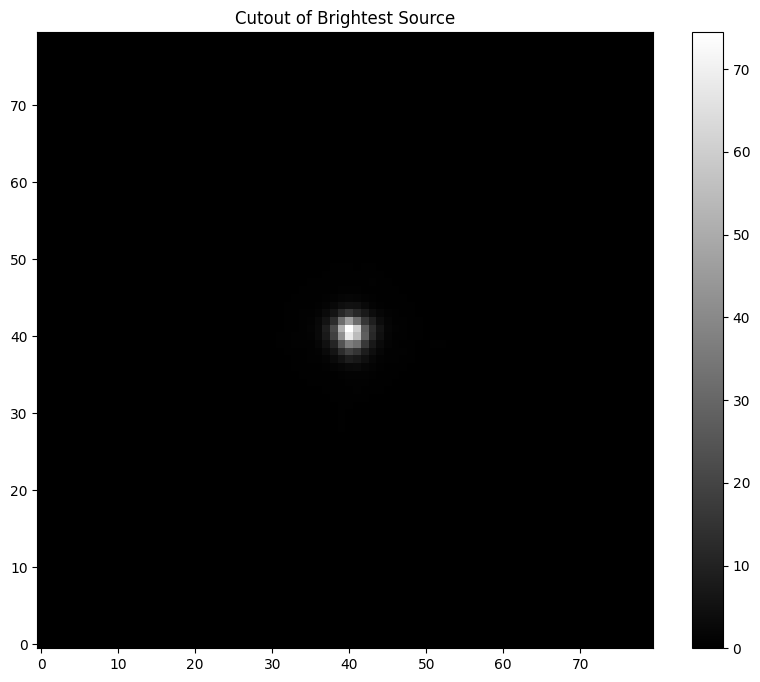

In [64]:
# show the cutout of the max flux
cut = data[int(ypos-40):int(ypos+40), int(xpos-40):int(xpos+40)]
plt.imshow(cut, cmap='grey', origin='lower')
plt.title('Cutout of Brightest Source')
plt.colorbar()
plt.savefig('udf_f105w_max_outlier_cutout.png', dpi=200)
plt.show()

In [65]:
# opens f125 and f106
hdu125 = fits.open(f125)
img125 = hdu125[0].data.astype(np.float32)  

hdu160 = fits.open(f160)
img160 = hdu160[0].data.astype(np.float32)  


(3600, 3600, 3)


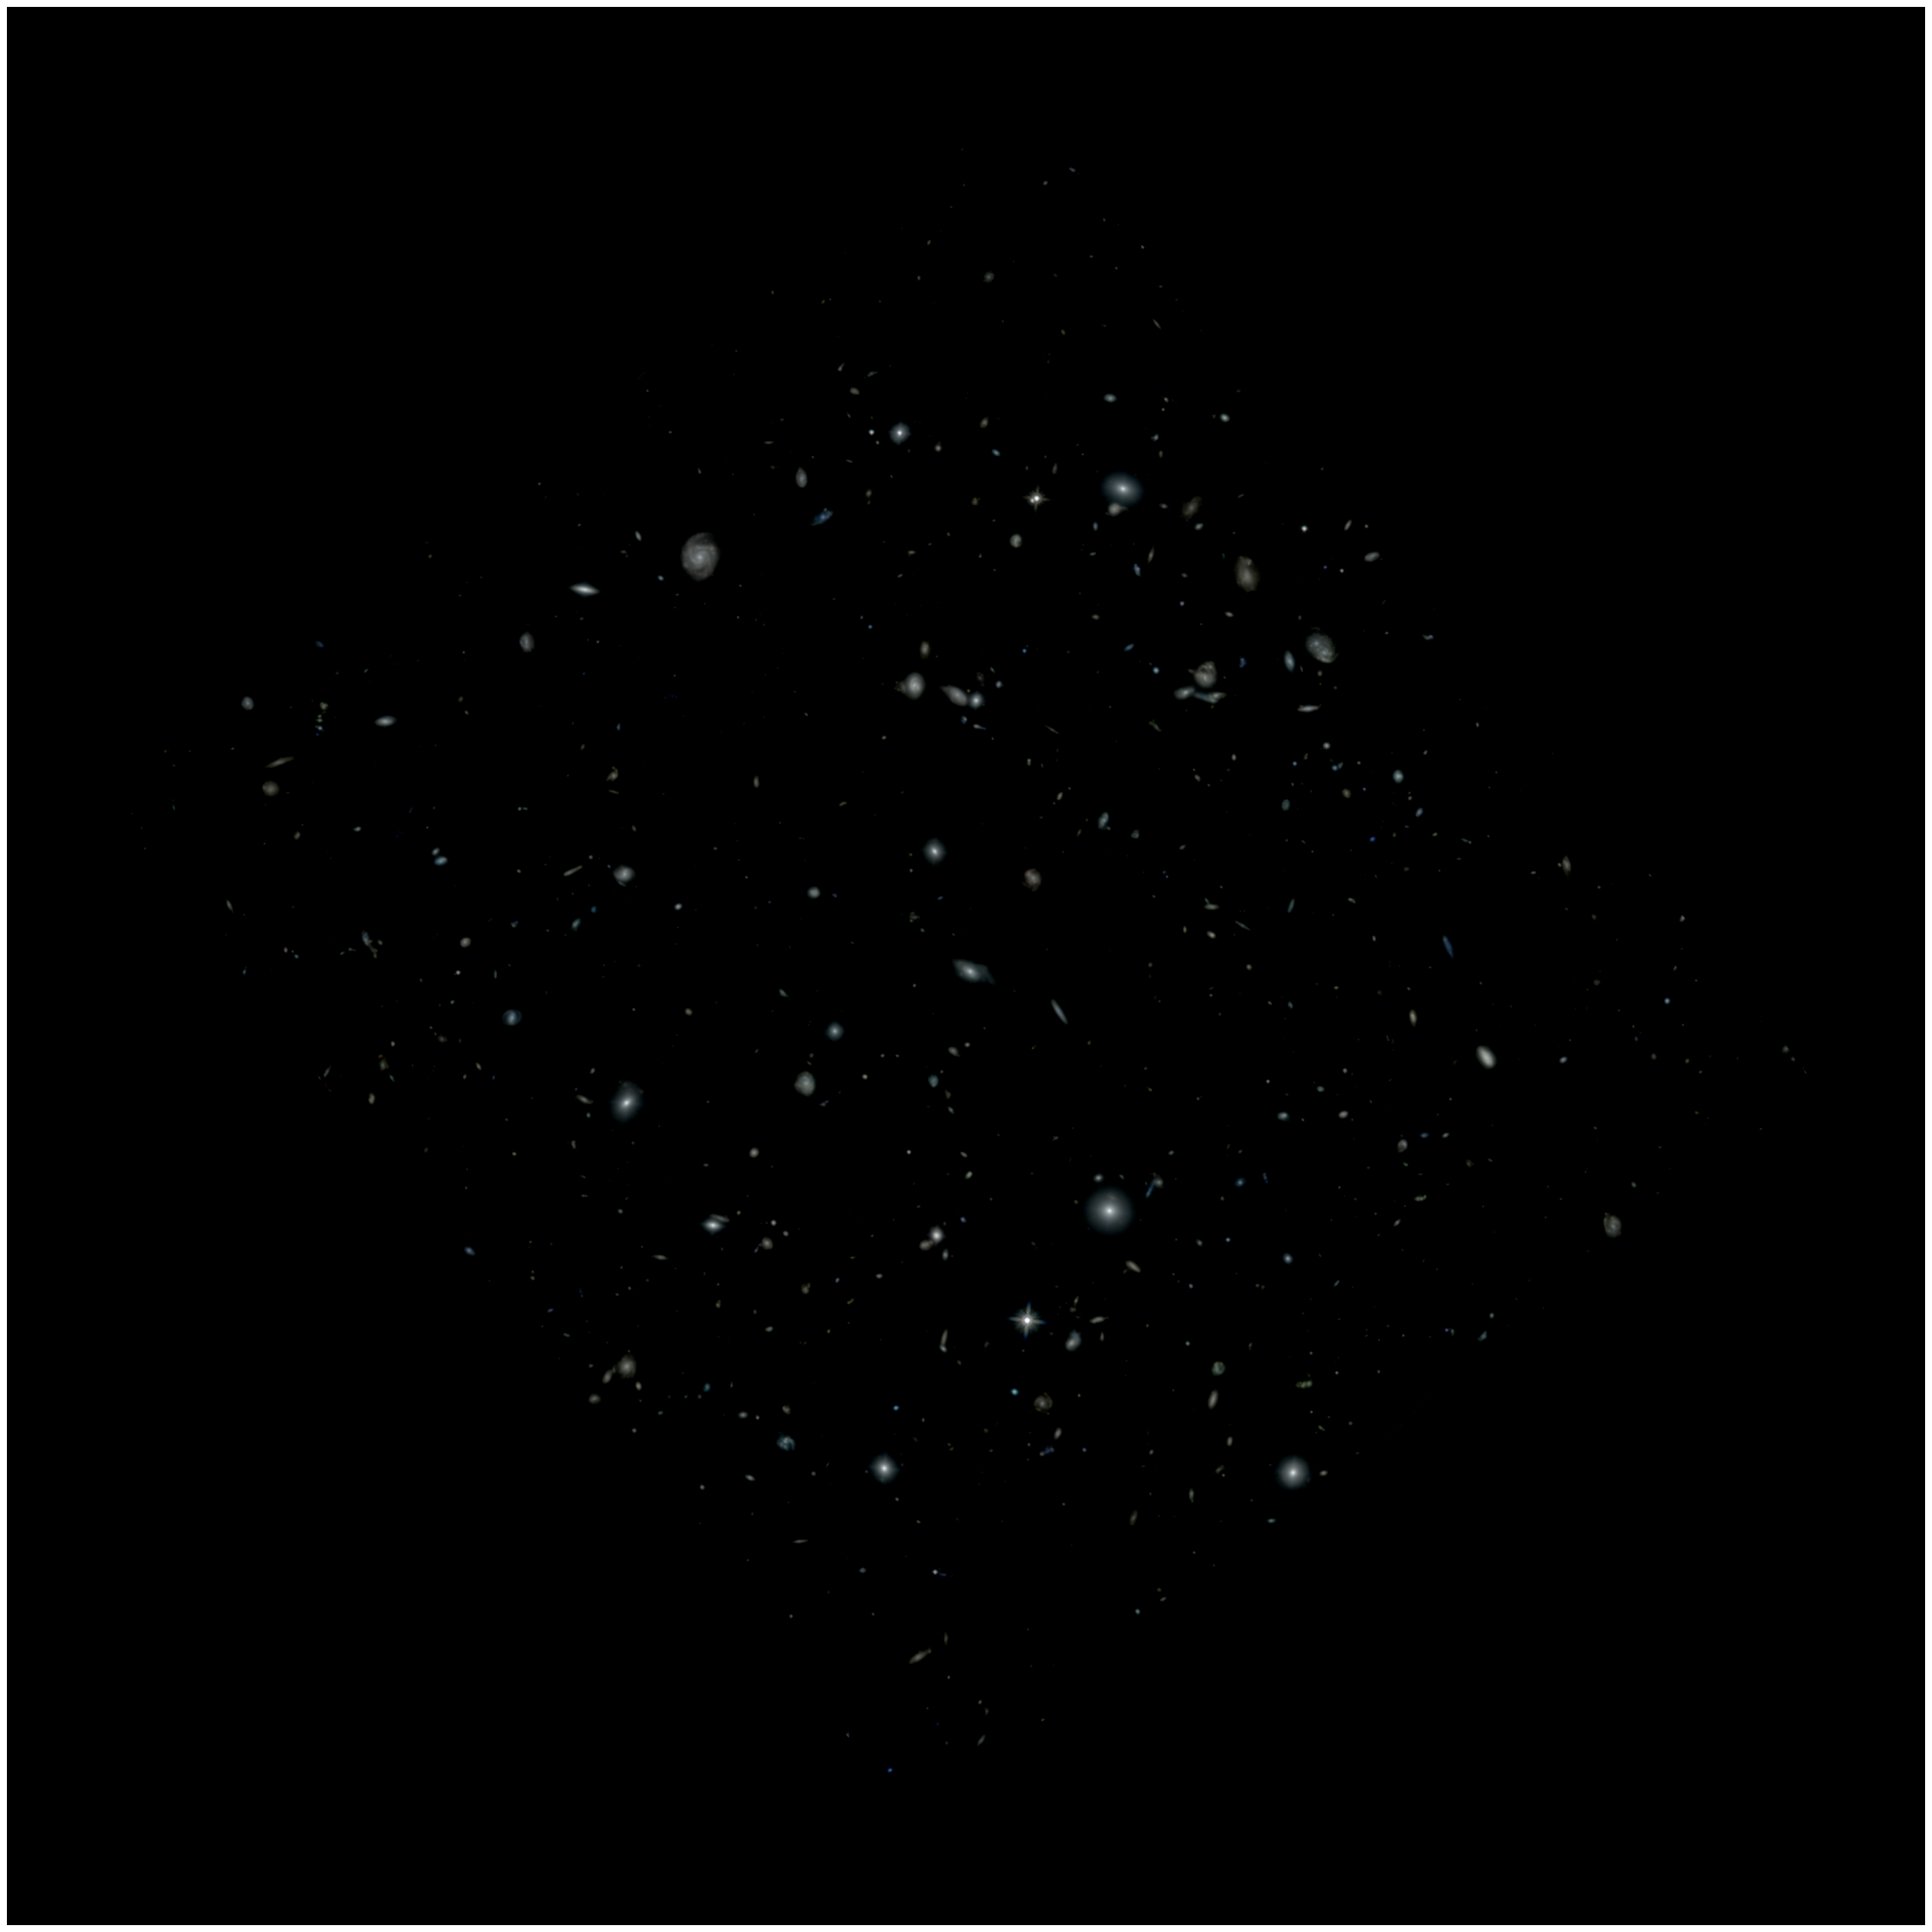

In [66]:
# overlap of f105, f125, f160
def rescale_data(data, dmin= 0.01, dmax= 10.0):
    datac = np.clip(data, dmin,dmax)
    return (np.log10(datac)-np.log10(dmin))/(np.log10(dmax)-np.log10(dmin))

p_f105 = rescale_data(data)
p_f125 = rescale_data(img125)
p_f160 = rescale_data(img160)

# add colors
rgb = np.stack([p_f105, p_f125, p_f160], axis = -1)
print(rgb.shape)

xsize = rgb.shape[1]
ysize = rgb.shape[0]

fig, ax = plt.subplots(1, 1, figsize=(xsize/100.0, ysize/100.0))
ax.axis('off')
ax.imshow(rgb, origin='lower')
plt.show()